In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
yolo_model2=YOLO('/content/drive/MyDrive/FYP/YOLO Models/(N)yolov8s_model4.pt')

In [ ]:
def compute_iou(box1, box2):
    """Compute IoU (Intersection over Union) between two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    # Compute intersection
    x_inter1 = max(x1, x1_p)
    y_inter1 = max(y1, y1_p)
    x_inter2 = min(x2, x2_p)
    y_inter2 = min(y2, y2_p)

    inter_area = max(0, x_inter2 - x_inter1) * max(0, y_inter2 - y_inter1)

    # Compute union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def non_maximum_suppression(boxes, iou_threshold):
    """
    Apply Non-Maximum Suppression (NMS) to remove redundant bounding boxes.
    Keep only the largest box in overlapping cases.
    """
    if len(boxes) == 0:
        return []

    # Sort boxes by area (largest first)
    boxes = sorted(boxes, key=lambda b: (b[2] - b[0]) * (b[3] - b[1]), reverse=True)
    selected_boxes = []

    while boxes:
        # Select the largest box
        chosen_box = boxes.pop(0)
        selected_boxes.append(chosen_box)

        # Remove boxes that overlap too much with the chosen box
        boxes = [box for box in boxes if compute_iou(chosen_box, box) < iou_threshold]

    return selected_boxes

def apply_cv_inside_box(image, box):
    """
    Apply HSV thresholding & contour detection within the given bounding box.
    Returns True if a tree trunk is detected within the box.
    """
    x_min, y_min, x_max, y_max = box
    cropped_region = image[y_min:y_max, x_min:x_max]

    # Convert to HSV
    hsv_cropped = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2HSV)

    # Define brownish tree trunk color range in HSV
    # lower_brown = np.array([10, 30, 30])
    # upper_brown = np.array([25, 255, 210])
    lower_brown = np.array([10, 50, 50])
    upper_brown = np.array([50, 255, 255])

    # Create a mask for tree trunks
    mask = cv2.inRange(hsv_cropped, lower_brown, upper_brown)

    # Find contours within the cropped region
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Define a minimum area threshold to filter out small detections
    min_area = 50000  # Adjust based on your dataset

    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            return True  # Confirmed tree trunk

    # plt.figure(figsize=(8, 6))
    # plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    # plt.axis("off")
    # plt.show()

    return False  # No valid tree trunk detected


def detect_tree_trunks(image_path):
    """Process a single image to detect tree trunks using YOLO + CV filtering + NMS."""

    # Load original image
    image = cv2.imread(image_path)
    orig_h, orig_w, _ = image.shape

    # YOLO expects a specific input size (check your model's default size)
    # input_size = 640  # Adjust based on your model's input
    # image_resized = cv2.resize(image, (input_size, input_size))

    # Run YOLO inference on the resized image
    results = yolo_model2(image)

    # Extract YOLO bounding boxes (already correctly scaled)
    yolo_boxes = []
    for result in results:
        for box in result.boxes.xyxy:  # YOLOv8 format (x_min, y_min, x_max, y_max)
            x_min, y_min, x_max, y_max = box.cpu().numpy().astype(int)
            yolo_boxes.append((x_min, y_min, x_max, y_max))

     # Apply Non-Maximum Suppression (NMS) to remove overlapping boxes
    yolo_boxes = non_maximum_suppression(yolo_boxes, iou_threshold=0.6)

    # Apply computer vision method inside YOLO bounding boxes
    confirmed_boxes = [box for box in yolo_boxes if apply_cv_inside_box(image, box)]

    # Draw final confirmed bounding boxes
    for (x_min, y_min, x_max, y_max) in confirmed_boxes:
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 12)  # Red box

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    print(f"Number of confirmed tree trunks: {len(confirmed_boxes)}")


0: 640x640 6 Mangrove_Trunks, 548.4ms
Speed: 5.0ms preprocess, 548.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


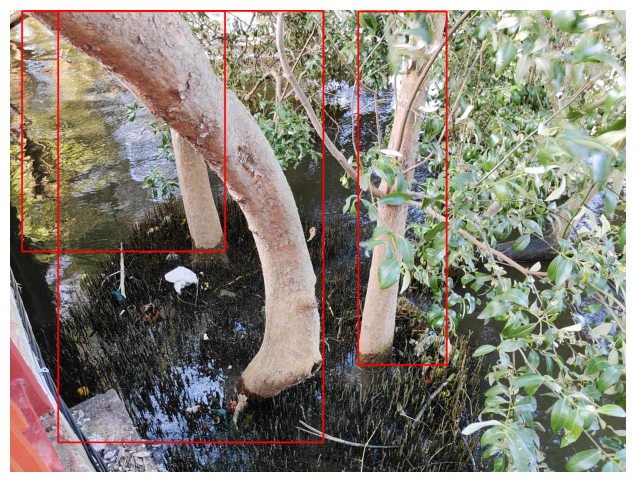

Number of confirmed tree trunks: 3


In [ ]:
# Run on a single image
detect_tree_trunks('/content/drive/MyDrive/FYP/Raw Data/030.jpg')


0: 640x640 5 Mangrove_Trunks, 847.7ms
Speed: 5.0ms preprocess, 847.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


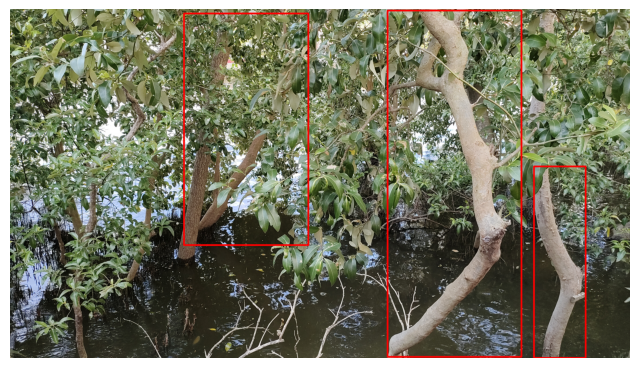

Number of confirmed tree trunks: 3


In [ ]:
detect_tree_trunks('/content/drive/MyDrive/FYP/Raw Data/065.jpg')


0: 384x640 5 Mangrove_Trunks, 350.7ms
Speed: 4.8ms preprocess, 350.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


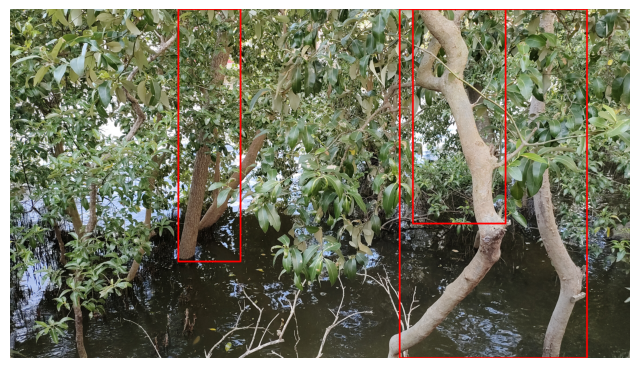

Number of confirmed tree trunks: 3


In [ ]:
detect_tree_trunks('/content/drive/MyDrive/FYP/Raw Data/065.jpg')


0: 480x640 4 Mangrove_Trunks, 429.8ms
Speed: 10.0ms preprocess, 429.8ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 640)


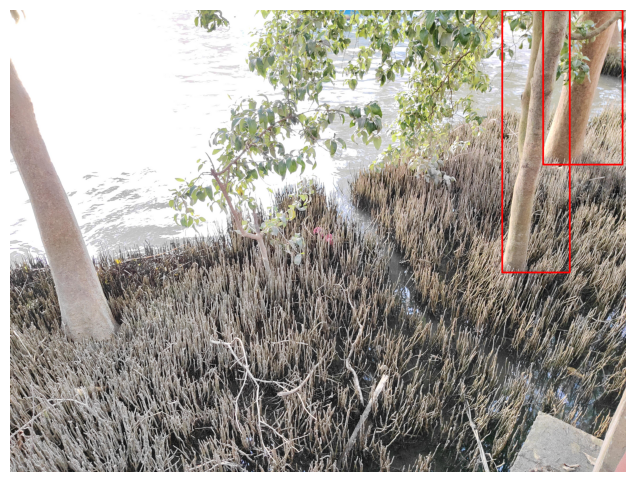

Number of confirmed tree trunks: 2


In [ ]:
detect_tree_trunks('/content/drive/MyDrive/FYP/Mangrove Detection.v6i.yolov11/test/images/IMG_20241207_182712_jpg.rf.a0f618b19686a845b5f4b06b96182fe8.jpg')


0: 480x640 10 Mangrove_Trunks, 337.7ms
Speed: 3.6ms preprocess, 337.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


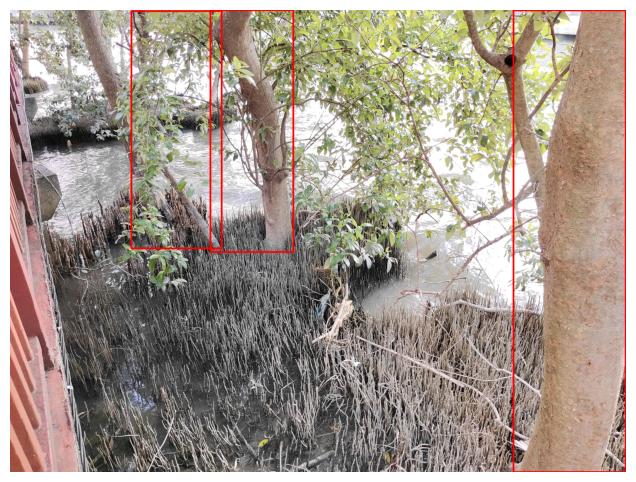

Number of confirmed tree trunks: 3


In [ ]:
detect_tree_trunks('/content/drive/MyDrive/FYP/Mangrove Detection.v6i.yolov11/test/images/IMG_20241207_183003_jpg.rf.a03f28ecddf96175399ddff4fb31c36f.jpg')


0: 480x640 7 Mangrove_Trunks, 519.2ms
Speed: 8.6ms preprocess, 519.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


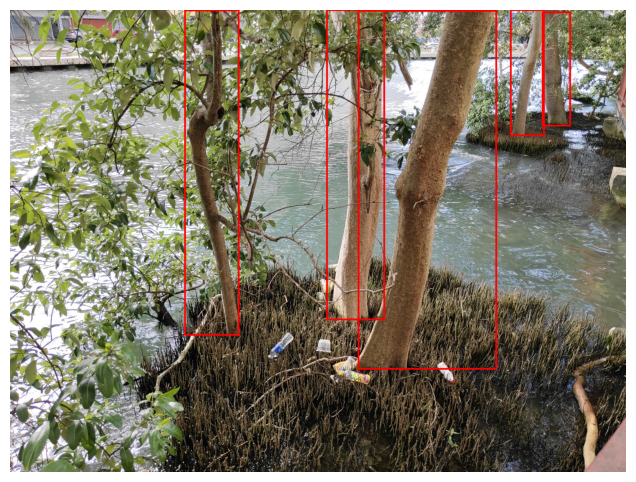

Number of confirmed tree trunks: 5


In [ ]:
detect_tree_trunks('/content/drive/MyDrive/FYP/Mangrove Detection.v6i.yolov11/test/images/IMG_20250302_164042_jpg.rf.ed40005b81bfe1835ecc4b6127de1c31.jpg')


0: 480x640 5 Mangrove_Trunks, 501.2ms
Speed: 7.5ms preprocess, 501.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


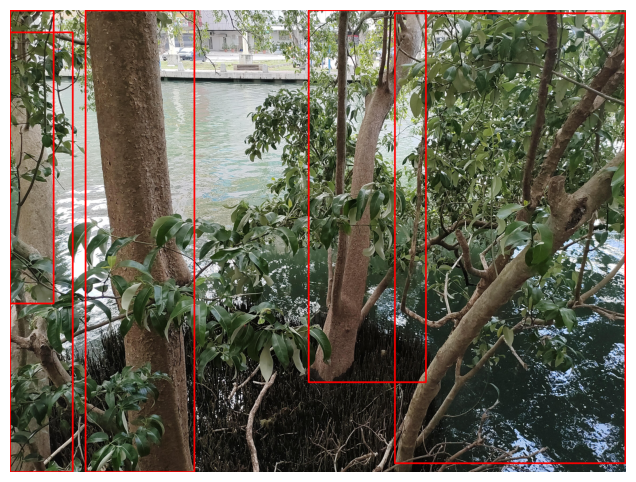

Number of confirmed tree trunks: 5


In [ ]:
detect_tree_trunks('/content/drive/MyDrive/FYP/Mangrove Detection.v6i.yolov11/test/images/IMG_20250302_164444_jpg.rf.8e03b5d7d2598107b738222e59cefc8a.jpg')

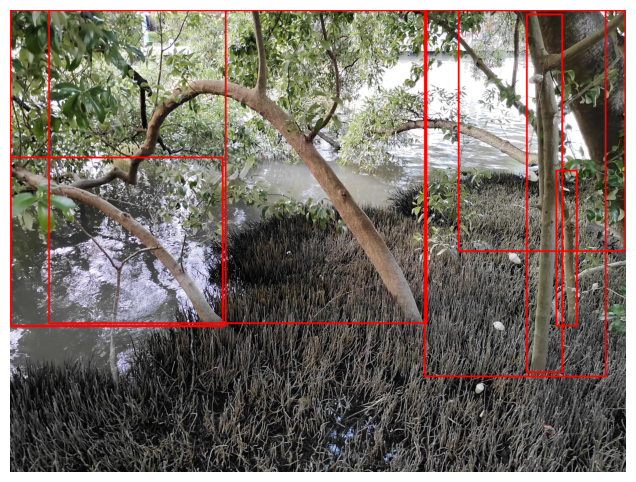

Number of confirmed tree trunks: 7


In [ ]:
detect_tree_trunks('/content/drive/MyDrive/FYP/Mangrove Detection.v6i.yolov11/test/images/IMG_20241207_183635_jpg.rf.7857d267de3497227e28ef4b6d2a6192.jpg')


0: 480x640 5 Mangrove_Trunks, 607.2ms
Speed: 5.5ms preprocess, 607.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


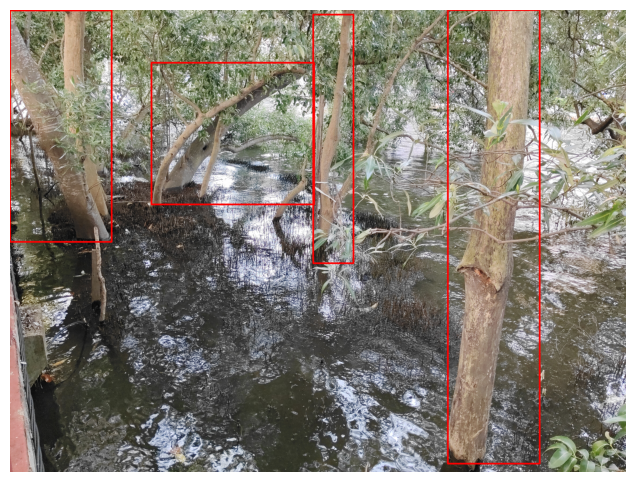

Number of confirmed tree trunks: 4


In [ ]:
detect_tree_trunks('/content/drive/MyDrive/FYP/Raw Data/050.jpg')

In [ ]:
yolo_model=YOLO('/content/drive/MyDrive/FYP/YOLO Models/(N)yolov8s_model4.pt')


0: 640x640 5 Mangrove_Trunks, 1373.1ms
Speed: 7.3ms preprocess, 1373.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


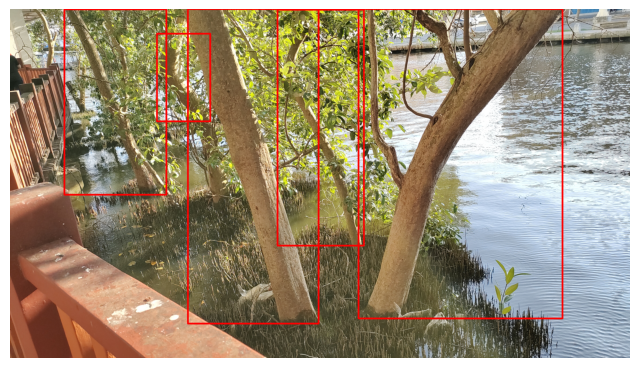

Number of confirmed tree trunks: 5


In [ ]:
detect_tree_trunks('/content/drive/MyDrive/FYP/Raw Data/049.jpg')